## RQ2

In [1]:
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt

## Data Loading

In [2]:
pr1 = pd.read_json("20230803_093947_pr_sharings.json")
pr2 = pd.read_json("20230810_123110_pr_sharings.json")
pr3 = pd.read_json("20230817_125147_pr_sharings.json")
pr4 = pd.read_json("20230824_100450_pr_sharings.json")
pr5 = pd.read_json("20230831_060603_pr_sharings.json")

commit1 = pd.read_json("20230803_095317_commit_sharings.json")
commit2 = pd.read_json("20230810_124807_commit_sharings.json")
commit3 = pd.read_json("20230817_131244_commit_sharings.json")
commit4 = pd.read_json("20230824_102435_commit_sharings.json")
commit5 = pd.read_json("20230831_063412_commit_sharings.json")

## Data Processing

In [3]:
pr1_n = pd.json_normalize(pr1['Sources'])
pr2_n = pd.json_normalize(pr2['Sources'])
pr3_n = pd.json_normalize(pr3['Sources'])
pr4_n = pd.json_normalize(pr4['Sources'])
pr5_n = pd.json_normalize(pr5['Sources'])

commit1_n = pd.json_normalize(commit1['Sources'])
commit2_n = pd.json_normalize(commit2['Sources'])
commit3_n = pd.json_normalize(commit3['Sources'])
commit4_n = pd.json_normalize(commit4['Sources'])
commit5_n = pd.json_normalize(commit5['Sources'])

In [4]:
pr_august = pd.concat([pr1_n, pr2_n, pr3_n, pr4_n, pr5_n])
commit_august = pd.concat([commit1_n, commit2_n, commit3_n, commit4_n, commit5_n])

pr_august_clean = pr_august.rename(columns={'CommitSha': 'Sha'})
commit_august_clean = commit_august

In [5]:
keywords = ["chat.openai.com", "GPT", "AI-generated"]

commit_august_clean = commit_august_clean.copy()

commit_august_clean.loc[:, "AI_Generated"] = commit_august_clean["Message"].astype(str).apply(
    lambda x: any(i in x for i in keywords)
)

commit_gpt_only = commit_august_clean.loc[commit_august_clean["AI_Generated"] == True].copy()
commit_gpt_only.head(2)

,Type,URL,Author,RepoName,RepoLanguage,Sha,Message,AuthorAt,CommitAt,ChatgptSharing,AI_Generated
0,commit,https://github.com/p3ob7o/Speak/commit/01cec3e...,p3ob7o,p3ob7o/Speak,None,01cec3e3d17e26f703ce8bf7aa068d3f6b6364d3,Refactored entirely based on https://chat.open...,2023-07-06T11:20:49.000-05:00,2023-07-06T11:20:49.000-05:00,[{'URL': 'https://chat.openai.com/share/c89e04...,True
1,commit,https://github.com/OKinane/spotify-to-youtube-...,OKinane,OKinane/spotify-to-youtube-chrome-extension,JavaScript,cad80ca0a31be41ebb36ef2d2cc48e7e43485552,follow the first chatgpt answer\n\nhttps://cha...,2023-07-11T20:26:51.000+01:00,2023-07-11T20:26:51.000+01:00,[{'URL': 'https://chat.openai.com/share/0f8a3c...,True


In [6]:
pr_august_clean_explode = pr_august_clean.explode("Sha")

In [7]:
commits_pr = commit_august_clean.merge(pr_august_clean_explode, on="Sha", how="left")

In [8]:
commits_pr.columns

Index(['Type_x', 'URL_x', 'Author_x', 'RepoName_x', 'RepoLanguage_x', 'Sha',
       'Message', 'AuthorAt', 'CommitAt', 'ChatgptSharing_x', 'AI_Generated',
       'Type_y', 'URL_y', 'Author_y', 'RepoName_y', 'RepoLanguage_y', 'Number',
       'Title', 'Body', 'CreatedAt', 'ClosedAt', 'MergedAt', 'UpdatedAt',
       'State', 'Additions', 'Deletions', 'ChangedFiles', 'CommitsTotalCount',
       'ChatgptSharing_y'],
      dtype='object')

In [9]:
commits_pr_clean = commits_pr.drop(columns=['Type_y', 'URL_y', 'Author_y', 'RepoName_y', 'RepoLanguage_y', 'ChatgptSharing_y'])

In [10]:
commits_pr_clean.astype(str).duplicated().sum()

45

In [11]:
processed_df = commits_pr_clean.astype(str).drop_duplicates()

In [12]:
processed_df.astype(str).duplicated().sum()

0

In [13]:
processed_df.to_csv('processed_df.csv', index=False)

## Analysis

> How are AI-generated commits used in software development? Specifically, which programming language has the most AI-generated commits, what time of day are these commits made, how many make it to a pull request, and how long does it take for them to reach a PR?

In [14]:
df = pd.read_csv("processed_df.csv")

df["CommitAt"] = pd.to_datetime(df["CommitAt"], errors='coerce', utc=True)
df["CreatedAt"] = pd.to_datetime(df["CreatedAt"], errors='coerce', utc=True)
df["MergedAt"] = pd.to_datetime(df["MergedAt"], errors='coerce', utc=True)

> **Which programming language has the most AI-generated commits?**

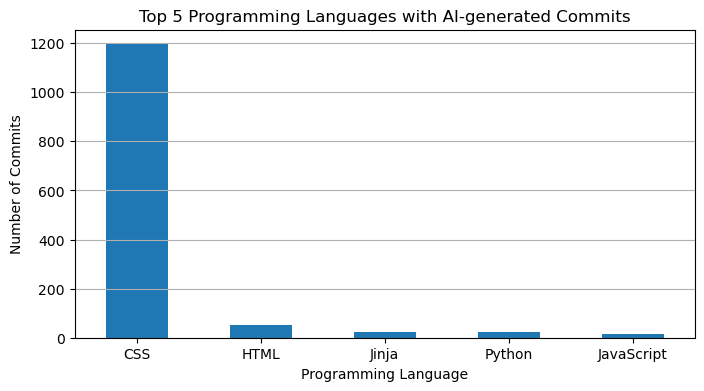

In [15]:
language_commit_counts = df["RepoLanguage_x"].value_counts()
plt.figure(figsize=(8, 4))
language_commit_counts.head(5).plot(kind="bar")
plt.title("Top 5 Programming Languages with AI-generated Commits")
plt.xlabel("Programming Language")
plt.ylabel("Number of Commits")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()

> **What time of day are these commits made?**

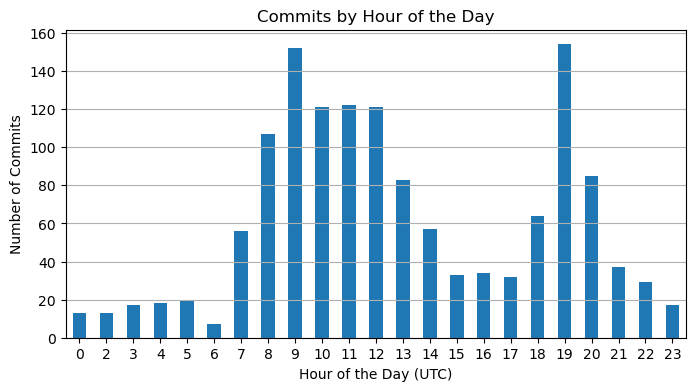

In [16]:
df["HourOfCommit"] = df["CommitAt"].dt.hour
time_of_day_counts = df["HourOfCommit"].value_counts().sort_index()

plt.figure(figsize=(8, 4))
time_of_day_counts.plot(kind="bar")
plt.title("Commits by Hour of the Day")
plt.xlabel("Hour of the Day (UTC)")
plt.ylabel("Number of Commits")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()

> **How many make it to a pull request?**

In [17]:
commits_with_pr = df["State"].notna().sum()
total_commits = len(df)
percentage_commits_to_pr = (commits_with_pr / total_commits) * 100
print(commits_with_pr)
print(total_commits)
print(percentage_commits_to_pr)

11
1392
0.7902298850574714


> **How long does it take for them to reach a PR?**

In [18]:
df["TimeToPR"] = (df["CreatedAt"] - df["CommitAt"]).dt.total_seconds() / 60  # Convert seconds to hours
avg_time_to_pr = abs(df["TimeToPR"].mean())
print(avg_time_to_pr, "Minutes")

8.1 Minutes
